# LightGBM for 血栓 Reduction Prediction

## Task
- Binary classification
- Target: 血栓 reduction (0 = 无, 1 = 有)

## Model
- LightGBM Classifier (lightgbm)

## Metrics
- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC
- PR-AUC

## Notes
This notebook serves as the comparison model.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

TARGET_COL = "动脉血栓（有1，无0）"
DATA_PATH = "../data/PLTdataset.xlsx"
SHEET_NAME = "血栓形成预测"

In [3]:
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)

print("Data shape:", df.shape)
df.head()

Data shape: (35, 33)


,Unnamed: 0,动脉血栓（有1，无0）,"FHb(1,>40mg/L;0,<40mg/L)","FHb(1,>40mg/L;0,<40mg/L).1","TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL)","TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL).1","脾大（1,是，0否）","PLA2（0<659IU/L,1≥659IU/L）","PLA2（0<659IU/L,1≥659IU/L）.1","HGB（1<100mg/L,0≥100mg/L）",...,STO,CRP,FIB,D dimer,NO,LDH,CHO,LDL,Pla(脂蛋白a),SOD
0,N1,0,19.974734,0,1260.021290,0,0,697,1,84,...,25.2,30.08,2.13,8.26,28.5,237,4.28,1.88,0.55,72
1,N10,1,20.367691,0,3922.861245,0,0,838,1,131,...,18.0,10.02,2.30,0.39,49.0,273,3.17,1.39,0.10,45
2,N12,0,14.744621,0,728.808820,0,0,811,1,145,...,5.0,26.00,2.30,0.66,30.0,216,7.82,3.94,0.31,90
3,N13,0,15.565815,0,947.037330,0,0,730,1,136,...,5.0,16.31,2.42,0.73,35.5,125,3.48,1.66,0.15,133
4,N14,0,14.744621,0,629.040860,0,0,504,0,128,...,3.0,62.74,5.58,2.00,32.9,152,4.08,2.20,0.08,139


In [4]:
df.info()

df[TARGET_COL].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unnamed: 0                                 35 non-null     object 
 1   动脉血栓（有1，无0）                                35 non-null     int64  
 2   FHb(1,>40mg/L;0,<40mg/L)                   35 non-null     float64
 3   FHb(1,>40mg/L;0,<40mg/L).1                 35 non-null     int64  
 4   TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL)    35 non-null     float64
 5   TM(>5450,1;≤5450，0，正常范围5450±2140)pg/mL).1  35 non-null     int64  
 6   脾大（1,是，0否）                                 35 non-null     int64  
 7   PLA2（0<659IU/L,1≥659IU/L）                  35 non-null     int64  
 8   PLA2（0<659IU/L,1≥659IU/L）.1                35 non-null     int64  
 9    HGB（1<100mg/L,0≥100mg/L）                  35 non-null     int64  
 10   HGB（1<100mg/L,2≥100mg/L）   

动脉血栓（有1，无0）
0    0.8
1    0.2
Name: proportion, dtype: float64

In [5]:
id_col_name = df.columns[0]
DROP_COLS = [id_col_name, TARGET_COL]
X = df.drop(columns=DROP_COLS)
y = df[TARGET_COL]

In [6]:
print("Missing values:")
print(X.isna().sum().sort_values(ascending=False))

X = X.dropna()
y = y.loc[X.index]

X = pd.get_dummies(X, drop_first=True)
print("Feature shape after encoding:", X.shape)

Missing values:
FHb(1,>40mg/L;0,<40mg/L)                     0
FVIII(0.<120;1,>120%).1                      0
Pla(脂蛋白a)                                    0
LDL                                          0
CHO                                          0
LDH                                          0
NO                                           0
D dimer                                      0
FIB                                          0
CRP                                          0
STO                                          0
NC                                           0
PLT count                                    0
WBC                                          0
Age                                          0
FVIII(0.<120;1,>120%)                        0
FHb(1,>40mg/L;0,<40mg/L).1                   0
HDL（0≥0.8mmol/L,1<0.8mmol/L）.1               0
HDL（0≥0.8mmol/L,1<0.8mmol/L）                 0
RDW1(0<15%,1≥15%.1                           0
RDW1(0<15%,1≥15%                            

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (28, 31)
Test: (7, 31)


In [8]:
model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

In [9]:
model.fit(X_train, y_train)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 6, number of negative: 22
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 28, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=200,
               random_state=42)

In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [11]:
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob),
    "pr_auc": average_precision_score(y_test, y_prob)
}

metrics_df = pd.DataFrame(metrics, index=["LightGBM"])
metrics_df

/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1,roc_auc,pr_auc
LightGBM,0.857143,0.0,0.0,0.0,0.5,0.142857


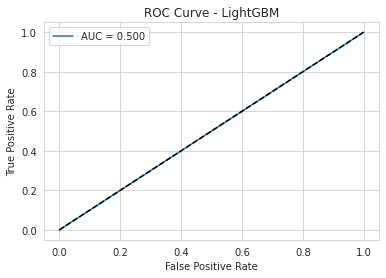

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.show()

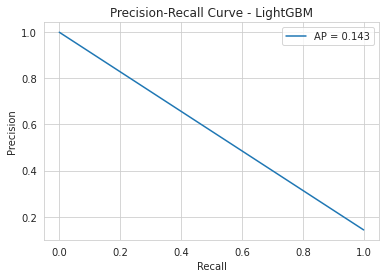

In [13]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, label=f"AP = {metrics['pr_auc']:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LightGBM")
plt.legend()
plt.show()

/tmp/ipykernel_866/2996859983.py:10: UserWarning: Glyph 33026 (\N{CJK UNIFIED IDEOGRAPH-8102}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_866/2996859983.py:10: UserWarning: Glyph 34507 (\N{CJK UNIFIED IDEOGRAPH-86CB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_866/2996859983.py:10: UserWarning: Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_866/2996859983.py:10: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_866/2996859983.py:10: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/root/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33026 (\N{CJK UNIFIED IDEOGRAPH-8102}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: Use

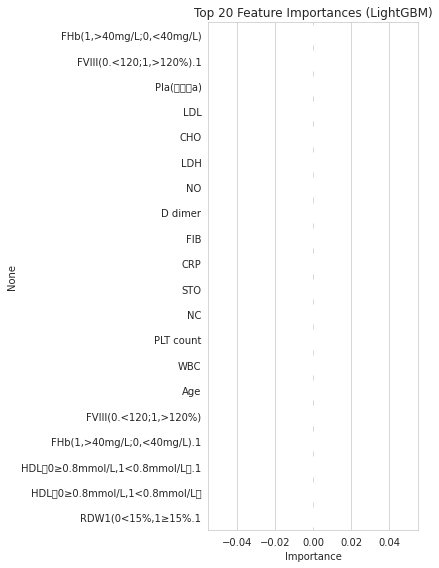

In [14]:
feat_imp = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.barplot(x=feat_imp.head(20), y=feat_imp.head(20).index)
plt.title("Top 20 Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [15]:
metrics_df.to_csv("../outputs/lgbm_metrics_03.csv")
feat_imp.to_csv("../outputs/lgbm_feature_importance_03.csv")

plt.savefig("../outputs/lgbm_feature_importance_03.png", dpi=300)

<Figure size 432x288 with 0 Axes>

## Summary

- Random Forest baseline completed
- PR-AUC suggests model performance under class imbalance
- Top features identified for further analysis

Next steps:
- XGBoost
- LightGBM
- Threshold tuning